# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 868us/sample - loss: 239.8984 - y1_output_loss: 115.4006 - y2_output_loss: 122.3722 - y1_output_root_mean_squared_error: 10.7899 - y2_output_root_mean_squared_error: 11.1119 - val_loss: 39.6749 - val_y1_output_loss: 17.4430 - val_y2_output_loss: 21.0927 - val_y1_output_root_mean_squared_error: 4.2221 - val_y2_output_root_mean_squared_error: 4.6743
Epoch 2/500
614/614 [==============================] - 0s 133us/sample - loss: 33.1148 - y1_output_loss: 12.6551 - y2_output_loss: 20.3025 - y1_output_root_mean_squared_error: 3.5642 - y2_output_root_mean_squared_error: 4.5179 - val_loss: 22.1422 - val_y1_output_loss: 10.1792 - val_y2_output_loss: 11.5819 - val_y1_output_root_mean_squared_error: 3.2021 - val_y2_output_root_mean_squared_error: 3.4480
Epoch 3/500
614/614 [==============================] - 0s 128us/sample - loss: 27.8618 - y1_output_loss: 10.3920 - y2_output_loss: 17.5184 - y1

614/614 [==============================] - 0s 125us/sample - loss: 15.5193 - y1_output_loss: 5.7362 - y2_output_loss: 9.6517 - y1_output_root_mean_squared_error: 2.4051 - y2_output_root_mean_squared_error: 3.1201 - val_loss: 13.1926 - val_y1_output_loss: 5.7469 - val_y2_output_loss: 7.6905 - val_y1_output_root_mean_squared_error: 2.3655 - val_y2_output_root_mean_squared_error: 2.7563
Epoch 22/500
614/614 [==============================] - 0s 125us/sample - loss: 19.0675 - y1_output_loss: 6.3846 - y2_output_loss: 12.5211 - y1_output_root_mean_squared_error: 2.5374 - y2_output_root_mean_squared_error: 3.5538 - val_loss: 13.1776 - val_y1_output_loss: 5.4327 - val_y2_output_loss: 7.9736 - val_y1_output_root_mean_squared_error: 2.3058 - val_y2_output_root_mean_squared_error: 2.8038
Epoch 23/500
614/614 [==============================] - 0s 124us/sample - loss: 17.7213 - y1_output_loss: 6.0337 - y2_output_loss: 11.5532 - y1_output_root_mean_squared_error: 2.4648 - y2_output_root_mean_squared

614/614 [==============================] - 0s 126us/sample - loss: 7.5698 - y1_output_loss: 2.4329 - y2_output_loss: 5.1232 - y1_output_root_mean_squared_error: 1.5631 - y2_output_root_mean_squared_error: 2.2642 - val_loss: 12.9422 - val_y1_output_loss: 2.8551 - val_y2_output_loss: 10.4767 - val_y1_output_root_mean_squared_error: 1.6513 - val_y2_output_root_mean_squared_error: 3.1961
Epoch 42/500
614/614 [==============================] - 0s 126us/sample - loss: 9.9611 - y1_output_loss: 2.9201 - y2_output_loss: 6.9759 - y1_output_root_mean_squared_error: 1.7168 - y2_output_root_mean_squared_error: 2.6483 - val_loss: 8.3298 - val_y1_output_loss: 2.5369 - val_y2_output_loss: 6.1475 - val_y1_output_root_mean_squared_error: 1.5400 - val_y2_output_root_mean_squared_error: 2.4409
Epoch 43/500
614/614 [==============================] - 0s 126us/sample - loss: 6.8910 - y1_output_loss: 2.1479 - y2_output_loss: 4.7234 - y1_output_root_mean_squared_error: 1.4634 - y2_output_root_mean_squared_erro

Epoch 62/500
614/614 [==============================] - 0s 123us/sample - loss: 5.6455 - y1_output_loss: 1.5923 - y2_output_loss: 4.0425 - y1_output_root_mean_squared_error: 1.2629 - y2_output_root_mean_squared_error: 2.0126 - val_loss: 9.0006 - val_y1_output_loss: 2.9035 - val_y2_output_loss: 5.9252 - val_y1_output_root_mean_squared_error: 1.7049 - val_y2_output_root_mean_squared_error: 2.4686
Epoch 63/500
614/614 [==============================] - 0s 123us/sample - loss: 5.2098 - y1_output_loss: 1.6762 - y2_output_loss: 3.5828 - y1_output_root_mean_squared_error: 1.2907 - y2_output_root_mean_squared_error: 1.8825 - val_loss: 11.2805 - val_y1_output_loss: 2.9176 - val_y2_output_loss: 8.5925 - val_y1_output_root_mean_squared_error: 1.6855 - val_y2_output_root_mean_squared_error: 2.9051
Epoch 64/500
614/614 [==============================] - 0s 124us/sample - loss: 5.1394 - y1_output_loss: 1.4987 - y2_output_loss: 3.6629 - y1_output_root_mean_squared_error: 1.2221 - y2_output_root_mean_

Epoch 83/500
614/614 [==============================] - 0s 124us/sample - loss: 2.9210 - y1_output_loss: 0.7054 - y2_output_loss: 2.2024 - y1_output_root_mean_squared_error: 0.8428 - y2_output_root_mean_squared_error: 1.4869 - val_loss: 4.9241 - val_y1_output_loss: 1.1105 - val_y2_output_loss: 3.8470 - val_y1_output_root_mean_squared_error: 1.0388 - val_y2_output_root_mean_squared_error: 1.9608
Epoch 84/500
614/614 [==============================] - 0s 123us/sample - loss: 2.7537 - y1_output_loss: 0.6665 - y2_output_loss: 2.0728 - y1_output_root_mean_squared_error: 0.8201 - y2_output_root_mean_squared_error: 1.4426 - val_loss: 3.9067 - val_y1_output_loss: 0.9040 - val_y2_output_loss: 2.9513 - val_y1_output_root_mean_squared_error: 0.9489 - val_y2_output_root_mean_squared_error: 1.7339
Epoch 85/500
614/614 [==============================] - 0s 123us/sample - loss: 4.7738 - y1_output_loss: 1.2120 - y2_output_loss: 3.5445 - y1_output_root_mean_squared_error: 1.1040 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 124us/sample - loss: 8.3435 - y1_output_loss: 2.3625 - y2_output_loss: 5.9475 - y1_output_root_mean_squared_error: 1.5411 - y2_output_root_mean_squared_error: 2.4431 - val_loss: 4.4220 - val_y1_output_loss: 1.2954 - val_y2_output_loss: 3.1195 - val_y1_output_root_mean_squared_error: 1.1393 - val_y2_output_root_mean_squared_error: 1.7675
Epoch 105/500
614/614 [==============================] - 0s 123us/sample - loss: 3.1333 - y1_output_loss: 0.7334 - y2_output_loss: 2.3800 - y1_output_root_mean_squared_error: 0.8563 - y2_output_root_mean_squared_error: 1.5492 - val_loss: 4.3529 - val_y1_output_loss: 0.7299 - val_y2_output_loss: 3.4991 - val_y1_output_root_mean_squared_error: 0.8542 - val_y2_output_root_mean_squared_error: 1.9035
Epoch 106/500
614/614 [==============================] - 0s 126us/sample - loss: 3.0639 - y1_output_loss: 0.6682 - y2_output_loss: 2.3752 - y1_output_root_mean_squared_error: 0.8197 - y2_output_root_mea

614/614 [==============================] - 0s 127us/sample - loss: 2.3813 - y1_output_loss: 0.5435 - y2_output_loss: 1.8303 - y1_output_root_mean_squared_error: 0.7403 - y2_output_root_mean_squared_error: 1.3540 - val_loss: 4.0001 - val_y1_output_loss: 0.6534 - val_y2_output_loss: 3.2395 - val_y1_output_root_mean_squared_error: 0.8097 - val_y2_output_root_mean_squared_error: 1.8288
Epoch 125/500
614/614 [==============================] - 0s 123us/sample - loss: 1.8489 - y1_output_loss: 0.4045 - y2_output_loss: 1.4749 - y1_output_root_mean_squared_error: 0.6341 - y2_output_root_mean_squared_error: 1.2028 - val_loss: 4.5442 - val_y1_output_loss: 0.8695 - val_y2_output_loss: 3.5725 - val_y1_output_root_mean_squared_error: 0.9344 - val_y2_output_root_mean_squared_error: 1.9160
Epoch 126/500
614/614 [==============================] - 0s 122us/sample - loss: 2.4258 - y1_output_loss: 0.5245 - y2_output_loss: 1.9268 - y1_output_root_mean_squared_error: 0.7250 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 128us/sample - loss: 1.8070 - y1_output_loss: 0.4216 - y2_output_loss: 1.3833 - y1_output_root_mean_squared_error: 0.6483 - y2_output_root_mean_squared_error: 1.1776 - val_loss: 2.1686 - val_y1_output_loss: 0.4149 - val_y2_output_loss: 1.6884 - val_y1_output_root_mean_squared_error: 0.6491 - val_y2_output_root_mean_squared_error: 1.3218
Epoch 146/500
614/614 [==============================] - 0s 129us/sample - loss: 1.9128 - y1_output_loss: 0.4212 - y2_output_loss: 1.5003 - y1_output_root_mean_squared_error: 0.6448 - y2_output_root_mean_squared_error: 1.2235 - val_loss: 3.8195 - val_y1_output_loss: 0.6579 - val_y2_output_loss: 3.0665 - val_y1_output_root_mean_squared_error: 0.8177 - val_y2_output_root_mean_squared_error: 1.7751
Epoch 147/500
614/614 [==============================] - 0s 124us/sample - loss: 1.7058 - y1_output_loss: 0.3897 - y2_output_loss: 1.3022 - y1_output_root_mean_squared_error: 0.6263 - y2_output_root_mea

614/614 [==============================] - 0s 135us/sample - loss: 1.6868 - y1_output_loss: 0.3959 - y2_output_loss: 1.2872 - y1_output_root_mean_squared_error: 0.6300 - y2_output_root_mean_squared_error: 1.1357 - val_loss: 2.5164 - val_y1_output_loss: 0.4584 - val_y2_output_loss: 2.0075 - val_y1_output_root_mean_squared_error: 0.6841 - val_y2_output_root_mean_squared_error: 1.4312
Epoch 166/500
614/614 [==============================] - 0s 129us/sample - loss: 1.5281 - y1_output_loss: 0.2875 - y2_output_loss: 1.2401 - y1_output_root_mean_squared_error: 0.5350 - y2_output_root_mean_squared_error: 1.1144 - val_loss: 3.2724 - val_y1_output_loss: 0.5681 - val_y2_output_loss: 2.6375 - val_y1_output_root_mean_squared_error: 0.7633 - val_y2_output_root_mean_squared_error: 1.6400
Epoch 167/500
614/614 [==============================] - 0s 129us/sample - loss: 1.8657 - y1_output_loss: 0.4368 - y2_output_loss: 1.4468 - y1_output_root_mean_squared_error: 0.6520 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 123us/sample - loss: 1.5034 - y1_output_loss: 0.3481 - y2_output_loss: 1.1634 - y1_output_root_mean_squared_error: 0.5926 - y2_output_root_mean_squared_error: 1.0735 - val_loss: 1.9410 - val_y1_output_loss: 0.4054 - val_y2_output_loss: 1.4889 - val_y1_output_root_mean_squared_error: 0.6411 - val_y2_output_root_mean_squared_error: 1.2369
Epoch 187/500
614/614 [==============================] - 0s 123us/sample - loss: 1.2916 - y1_output_loss: 0.2694 - y2_output_loss: 1.0343 - y1_output_root_mean_squared_error: 0.5186 - y2_output_root_mean_squared_error: 1.0112 - val_loss: 1.8014 - val_y1_output_loss: 0.2706 - val_y2_output_loss: 1.4918 - val_y1_output_root_mean_squared_error: 0.5242 - val_y2_output_root_mean_squared_error: 1.2356
Epoch 188/500
614/614 [==============================] - 0s 124us/sample - loss: 1.3704 - y1_output_loss: 0.3080 - y2_output_loss: 1.0523 - y1_output_root_mean_squared_error: 0.5571 - y2_output_root_mea

614/614 [==============================] - 0s 123us/sample - loss: 1.3651 - y1_output_loss: 0.2753 - y2_output_loss: 1.0780 - y1_output_root_mean_squared_error: 0.5265 - y2_output_root_mean_squared_error: 1.0430 - val_loss: 1.4957 - val_y1_output_loss: 0.2515 - val_y2_output_loss: 1.2172 - val_y1_output_root_mean_squared_error: 0.5026 - val_y2_output_root_mean_squared_error: 1.1150
Epoch 207/500
614/614 [==============================] - 0s 123us/sample - loss: 1.4199 - y1_output_loss: 0.2565 - y2_output_loss: 1.1717 - y1_output_root_mean_squared_error: 0.5052 - y2_output_root_mean_squared_error: 1.0792 - val_loss: 1.5240 - val_y1_output_loss: 0.2946 - val_y2_output_loss: 1.2023 - val_y1_output_root_mean_squared_error: 0.5456 - val_y2_output_root_mean_squared_error: 1.1074
Epoch 208/500
614/614 [==============================] - 0s 124us/sample - loss: 1.4640 - y1_output_loss: 0.2850 - y2_output_loss: 1.2004 - y1_output_root_mean_squared_error: 0.5356 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 129us/sample - loss: 2.3307 - y1_output_loss: 0.6011 - y2_output_loss: 1.7130 - y1_output_root_mean_squared_error: 0.7789 - y2_output_root_mean_squared_error: 1.3130 - val_loss: 2.2370 - val_y1_output_loss: 0.2970 - val_y2_output_loss: 1.9015 - val_y1_output_root_mean_squared_error: 0.5468 - val_y2_output_root_mean_squared_error: 1.3921
Epoch 228/500
614/614 [==============================] - 0s 125us/sample - loss: 1.2676 - y1_output_loss: 0.2714 - y2_output_loss: 0.9915 - y1_output_root_mean_squared_error: 0.5214 - y2_output_root_mean_squared_error: 0.9978 - val_loss: 1.5254 - val_y1_output_loss: 0.2621 - val_y2_output_loss: 1.2254 - val_y1_output_root_mean_squared_error: 0.5158 - val_y2_output_root_mean_squared_error: 1.1222
Epoch 229/500
614/614 [==============================] - 0s 124us/sample - loss: 1.4716 - y1_output_loss: 0.2732 - y2_output_loss: 1.1886 - y1_output_root_mean_squared_error: 0.5229 - y2_output_root_mea

614/614 [==============================] - 0s 123us/sample - loss: 1.1636 - y1_output_loss: 0.3007 - y2_output_loss: 0.8571 - y1_output_root_mean_squared_error: 0.5499 - y2_output_root_mean_squared_error: 0.9280 - val_loss: 2.3679 - val_y1_output_loss: 0.3653 - val_y2_output_loss: 1.9897 - val_y1_output_root_mean_squared_error: 0.6108 - val_y2_output_root_mean_squared_error: 1.4124
Epoch 248/500
614/614 [==============================] - 0s 123us/sample - loss: 0.8691 - y1_output_loss: 0.1964 - y2_output_loss: 0.6679 - y1_output_root_mean_squared_error: 0.4441 - y2_output_root_mean_squared_error: 0.8197 - val_loss: 1.7848 - val_y1_output_loss: 0.2508 - val_y2_output_loss: 1.5479 - val_y1_output_root_mean_squared_error: 0.4990 - val_y2_output_root_mean_squared_error: 1.2393
Epoch 249/500
614/614 [==============================] - 0s 123us/sample - loss: 1.1134 - y1_output_loss: 0.2300 - y2_output_loss: 0.8981 - y1_output_root_mean_squared_error: 0.4780 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 127us/sample - loss: 0.9488 - y1_output_loss: 0.2233 - y2_output_loss: 0.7201 - y1_output_root_mean_squared_error: 0.4745 - y2_output_root_mean_squared_error: 0.8507 - val_loss: 1.0996 - val_y1_output_loss: 0.1629 - val_y2_output_loss: 0.9229 - val_y1_output_root_mean_squared_error: 0.4063 - val_y2_output_root_mean_squared_error: 0.9667
Epoch 269/500
614/614 [==============================] - 0s 128us/sample - loss: 1.9565 - y1_output_loss: 0.5814 - y2_output_loss: 1.3654 - y1_output_root_mean_squared_error: 0.7653 - y2_output_root_mean_squared_error: 1.1708 - val_loss: 1.2128 - val_y1_output_loss: 0.1752 - val_y2_output_loss: 1.0288 - val_y1_output_root_mean_squared_error: 0.4213 - val_y2_output_root_mean_squared_error: 1.0175
Epoch 270/500
614/614 [==============================] - 0s 129us/sample - loss: 1.3922 - y1_output_loss: 0.2677 - y2_output_loss: 1.1182 - y1_output_root_mean_squared_error: 0.5194 - y2_output_root_mea

614/614 [==============================] - 0s 124us/sample - loss: 0.8365 - y1_output_loss: 0.1794 - y2_output_loss: 0.6513 - y1_output_root_mean_squared_error: 0.4250 - y2_output_root_mean_squared_error: 0.8099 - val_loss: 1.1850 - val_y1_output_loss: 0.1597 - val_y2_output_loss: 1.0210 - val_y1_output_root_mean_squared_error: 0.4013 - val_y2_output_root_mean_squared_error: 1.0119
Epoch 289/500
614/614 [==============================] - 0s 123us/sample - loss: 1.1188 - y1_output_loss: 0.2538 - y2_output_loss: 0.8630 - y1_output_root_mean_squared_error: 0.5010 - y2_output_root_mean_squared_error: 0.9316 - val_loss: 1.1949 - val_y1_output_loss: 0.1941 - val_y2_output_loss: 0.9862 - val_y1_output_root_mean_squared_error: 0.4434 - val_y2_output_root_mean_squared_error: 0.9992
Epoch 290/500
614/614 [==============================] - 0s 123us/sample - loss: 1.0900 - y1_output_loss: 0.2614 - y2_output_loss: 0.8279 - y1_output_root_mean_squared_error: 0.5103 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 125us/sample - loss: 0.8691 - y1_output_loss: 0.2072 - y2_output_loss: 0.6645 - y1_output_root_mean_squared_error: 0.4498 - y2_output_root_mean_squared_error: 0.8166 - val_loss: 1.5878 - val_y1_output_loss: 0.3432 - val_y2_output_loss: 1.2159 - val_y1_output_root_mean_squared_error: 0.5913 - val_y2_output_root_mean_squared_error: 1.1128
Epoch 310/500
614/614 [==============================] - 0s 126us/sample - loss: 0.8990 - y1_output_loss: 0.1763 - y2_output_loss: 0.7184 - y1_output_root_mean_squared_error: 0.4207 - y2_output_root_mean_squared_error: 0.8497 - val_loss: 1.3000 - val_y1_output_loss: 0.2582 - val_y2_output_loss: 1.0324 - val_y1_output_root_mean_squared_error: 0.5105 - val_y2_output_root_mean_squared_error: 1.0195
Epoch 311/500
614/614 [==============================] - 0s 123us/sample - loss: 1.0938 - y1_output_loss: 0.2371 - y2_output_loss: 0.8498 - y1_output_root_mean_squared_error: 0.4886 - y2_output_root_mea

614/614 [==============================] - 0s 128us/sample - loss: 1.6128 - y1_output_loss: 0.4664 - y2_output_loss: 1.1403 - y1_output_root_mean_squared_error: 0.6839 - y2_output_root_mean_squared_error: 1.0700 - val_loss: 2.1708 - val_y1_output_loss: 0.3982 - val_y2_output_loss: 1.7386 - val_y1_output_root_mean_squared_error: 0.6331 - val_y2_output_root_mean_squared_error: 1.3304
Epoch 330/500
614/614 [==============================] - 0s 126us/sample - loss: 0.8626 - y1_output_loss: 0.1919 - y2_output_loss: 0.6739 - y1_output_root_mean_squared_error: 0.4353 - y2_output_root_mean_squared_error: 0.8204 - val_loss: 3.2089 - val_y1_output_loss: 0.7656 - val_y2_output_loss: 2.4531 - val_y1_output_root_mean_squared_error: 0.8779 - val_y2_output_root_mean_squared_error: 1.5615
Epoch 331/500
614/614 [==============================] - 0s 126us/sample - loss: 0.9598 - y1_output_loss: 0.2173 - y2_output_loss: 0.7461 - y1_output_root_mean_squared_error: 0.4660 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 126us/sample - loss: 0.5782 - y1_output_loss: 0.1547 - y2_output_loss: 0.4238 - y1_output_root_mean_squared_error: 0.3929 - y2_output_root_mean_squared_error: 0.6511 - val_loss: 1.6625 - val_y1_output_loss: 0.3144 - val_y2_output_loss: 1.3732 - val_y1_output_root_mean_squared_error: 0.5601 - val_y2_output_root_mean_squared_error: 1.1614
Epoch 351/500
614/614 [==============================] - 0s 125us/sample - loss: 0.7449 - y1_output_loss: 0.2033 - y2_output_loss: 0.5496 - y1_output_root_mean_squared_error: 0.4514 - y2_output_root_mean_squared_error: 0.7356 - val_loss: 2.5212 - val_y1_output_loss: 0.2581 - val_y2_output_loss: 2.2064 - val_y1_output_root_mean_squared_error: 0.5119 - val_y2_output_root_mean_squared_error: 1.5031
Epoch 352/500
614/614 [==============================] - 0s 124us/sample - loss: 1.1497 - y1_output_loss: 0.3028 - y2_output_loss: 0.8523 - y1_output_root_mean_squared_error: 0.5512 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 0.6295 - y1_output_loss: 0.1625 - y2_output_loss: 0.4636 - y1_output_root_mean_squared_error: 0.4043 - y2_output_root_mean_squared_error: 0.6827 - val_loss: 1.2474 - val_y1_output_loss: 0.1598 - val_y2_output_loss: 1.0637 - val_y1_output_root_mean_squared_error: 0.4010 - val_y2_output_root_mean_squared_error: 1.0424
Epoch 371/500
614/614 [==============================] - 0s 125us/sample - loss: 1.0485 - y1_output_loss: 0.2613 - y2_output_loss: 0.7816 - y1_output_root_mean_squared_error: 0.5119 - y2_output_root_mean_squared_error: 0.8868 - val_loss: 1.4398 - val_y1_output_loss: 0.3067 - val_y2_output_loss: 1.1443 - val_y1_output_root_mean_squared_error: 0.5573 - val_y2_output_root_mean_squared_error: 1.0627
Epoch 372/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5144 - y1_output_loss: 0.1573 - y2_output_loss: 0.3666 - y1_output_root_mean_squared_error: 0.3908 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4758 - y1_output_loss: 0.1509 - y2_output_loss: 0.3212 - y1_output_root_mean_squared_error: 0.3895 - y2_output_root_mean_squared_error: 0.5693 - val_loss: 1.0392 - val_y1_output_loss: 0.2071 - val_y2_output_loss: 0.8207 - val_y1_output_root_mean_squared_error: 0.4575 - val_y2_output_root_mean_squared_error: 0.9110
Epoch 392/500
614/614 [==============================] - 0s 124us/sample - loss: 0.5397 - y1_output_loss: 0.1549 - y2_output_loss: 0.3815 - y1_output_root_mean_squared_error: 0.3953 - y2_output_root_mean_squared_error: 0.6193 - val_loss: 1.7937 - val_y1_output_loss: 0.1730 - val_y2_output_loss: 1.6283 - val_y1_output_root_mean_squared_error: 0.4181 - val_y2_output_root_mean_squared_error: 1.2724
Epoch 393/500
614/614 [==============================] - 0s 123us/sample - loss: 0.5938 - y1_output_loss: 0.1623 - y2_output_loss: 0.4286 - y1_output_root_mean_squared_error: 0.4037 - y2_output_root_mea

614/614 [==============================] - 0s 124us/sample - loss: 0.6581 - y1_output_loss: 0.1517 - y2_output_loss: 0.5017 - y1_output_root_mean_squared_error: 0.3908 - y2_output_root_mean_squared_error: 0.7109 - val_loss: 1.1268 - val_y1_output_loss: 0.1754 - val_y2_output_loss: 0.9452 - val_y1_output_root_mean_squared_error: 0.4186 - val_y2_output_root_mean_squared_error: 0.9755
Epoch 412/500
614/614 [==============================] - 0s 127us/sample - loss: 0.5556 - y1_output_loss: 0.1511 - y2_output_loss: 0.4116 - y1_output_root_mean_squared_error: 0.3901 - y2_output_root_mean_squared_error: 0.6352 - val_loss: 1.8594 - val_y1_output_loss: 0.2100 - val_y2_output_loss: 1.6154 - val_y1_output_root_mean_squared_error: 0.4607 - val_y2_output_root_mean_squared_error: 1.2834
Epoch 413/500
614/614 [==============================] - 0s 125us/sample - loss: 0.5646 - y1_output_loss: 0.1554 - y2_output_loss: 0.4061 - y1_output_root_mean_squared_error: 0.3939 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4552 - y1_output_loss: 0.1349 - y2_output_loss: 0.3183 - y1_output_root_mean_squared_error: 0.3675 - y2_output_root_mean_squared_error: 0.5658 - val_loss: 1.0076 - val_y1_output_loss: 0.1979 - val_y2_output_loss: 0.8218 - val_y1_output_root_mean_squared_error: 0.4488 - val_y2_output_root_mean_squared_error: 0.8979
Epoch 433/500
614/614 [==============================] - 0s 125us/sample - loss: 0.4781 - y1_output_loss: 0.1346 - y2_output_loss: 0.3443 - y1_output_root_mean_squared_error: 0.3673 - y2_output_root_mean_squared_error: 0.5858 - val_loss: 1.4620 - val_y1_output_loss: 0.1833 - val_y2_output_loss: 1.3069 - val_y1_output_root_mean_squared_error: 0.4299 - val_y2_output_root_mean_squared_error: 1.1301
Epoch 434/500
614/614 [==============================] - 0s 123us/sample - loss: 0.4209 - y1_output_loss: 0.1368 - y2_output_loss: 0.2844 - y1_output_root_mean_squared_error: 0.3686 - y2_output_root_mea

614/614 [==============================] - 0s 127us/sample - loss: 0.6159 - y1_output_loss: 0.1677 - y2_output_loss: 0.4695 - y1_output_root_mean_squared_error: 0.4058 - y2_output_root_mean_squared_error: 0.6717 - val_loss: 2.5518 - val_y1_output_loss: 0.4499 - val_y2_output_loss: 2.1025 - val_y1_output_root_mean_squared_error: 0.6761 - val_y2_output_root_mean_squared_error: 1.4473
Epoch 453/500
614/614 [==============================] - 0s 128us/sample - loss: 0.7415 - y1_output_loss: 0.1867 - y2_output_loss: 0.5515 - y1_output_root_mean_squared_error: 0.4335 - y2_output_root_mean_squared_error: 0.7440 - val_loss: 1.0890 - val_y1_output_loss: 0.1997 - val_y2_output_loss: 0.8803 - val_y1_output_root_mean_squared_error: 0.4514 - val_y2_output_root_mean_squared_error: 0.9409
Epoch 454/500
614/614 [==============================] - 0s 124us/sample - loss: 0.4574 - y1_output_loss: 0.1272 - y2_output_loss: 0.3357 - y1_output_root_mean_squared_error: 0.3574 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 125us/sample - loss: 0.3960 - y1_output_loss: 0.1325 - y2_output_loss: 0.2636 - y1_output_root_mean_squared_error: 0.3647 - y2_output_root_mean_squared_error: 0.5128 - val_loss: 1.2673 - val_y1_output_loss: 0.1677 - val_y2_output_loss: 1.1223 - val_y1_output_root_mean_squared_error: 0.4102 - val_y2_output_root_mean_squared_error: 1.0483
Epoch 474/500
614/614 [==============================] - 0s 125us/sample - loss: 0.7251 - y1_output_loss: 0.1681 - y2_output_loss: 0.5591 - y1_output_root_mean_squared_error: 0.4117 - y2_output_root_mean_squared_error: 0.7454 - val_loss: 1.0716 - val_y1_output_loss: 0.1350 - val_y2_output_loss: 0.9638 - val_y1_output_root_mean_squared_error: 0.3667 - val_y2_output_root_mean_squared_error: 0.9680
Epoch 475/500
614/614 [==============================] - 0s 128us/sample - loss: 0.5845 - y1_output_loss: 0.1663 - y2_output_loss: 0.4180 - y1_output_root_mean_squared_error: 0.4070 - y2_output_root_mea

614/614 [==============================] - 0s 126us/sample - loss: 0.4464 - y1_output_loss: 0.1371 - y2_output_loss: 0.3102 - y1_output_root_mean_squared_error: 0.3691 - y2_output_root_mean_squared_error: 0.5569 - val_loss: 1.5629 - val_y1_output_loss: 0.3413 - val_y2_output_loss: 1.1886 - val_y1_output_root_mean_squared_error: 0.5904 - val_y2_output_root_mean_squared_error: 1.1020
Epoch 494/500
614/614 [==============================] - 0s 125us/sample - loss: 0.6244 - y1_output_loss: 0.1604 - y2_output_loss: 0.4590 - y1_output_root_mean_squared_error: 0.4014 - y2_output_root_mean_squared_error: 0.6806 - val_loss: 0.8666 - val_y1_output_loss: 0.1478 - val_y2_output_loss: 0.7368 - val_y1_output_root_mean_squared_error: 0.3841 - val_y2_output_root_mean_squared_error: 0.8480
Epoch 495/500
614/614 [==============================] - 0s 126us/sample - loss: 0.4653 - y1_output_loss: 0.1423 - y2_output_loss: 0.3197 - y1_output_root_mean_squared_error: 0.3786 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 30us/sample - loss: 1.0986 - y1_output_loss: 0.2344 - y2_output_loss: 0.8762 - y1_output_root_mean_squared_error: 0.4837 - y2_output_root_mean_squared_error: 0.9299
Loss = 1.0986226100426215, Y1_loss = 0.23436138033866882, Y1_mse = 0.48366832733154297, Y2_loss = 0.8762450218200684, Y2_mse = 0.9298858046531677


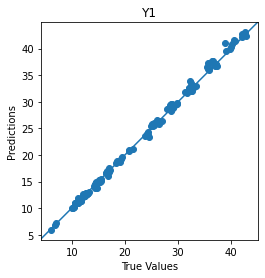

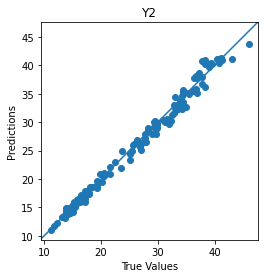

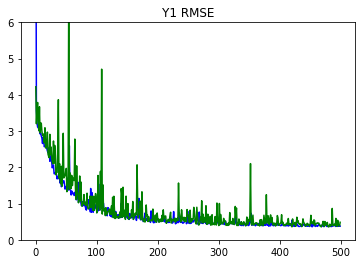

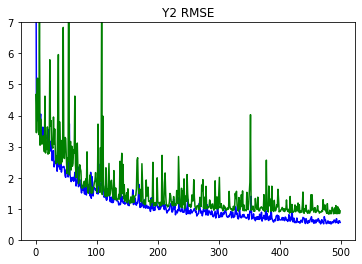

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)